# Exercises

In this exercise, we will implement the closed-shell restricted ADC(1) matrix yourself and diagonalize it to obtain excitation energies. We will use [Gator](sec:gator) to compare the results and obtain both singlet and triplet excitation energies. Furthermore, we will consider the core-valence separation (CVS) approximation for the calculation of core-excited states.

First, we define a small molecule (lithium hydride) and minimal basis set (STO-3G).

In [1]:
import veloxchem as vlx
import gator
import py3Dmol as p3d
import numpy as np
from veloxchem.mointsdriver import MOIntegralsDriver

np.set_printoptions(precision=5, suppress=True)
# Conversion from Hartree to eV for later use
au2ev = vlx.veloxchemlib.hartree_in_ev()
print(au2ev)

lih_xyz="""2

Li  0.000000   0.000000   0.000000
H   0.000000   0.000000   1.000000
"""
lih = vlx.Molecule.from_xyz_string(lih_xyz)

# Method and basis set
method = 'adc1'
basis_set_label = "sto-3g"
basis = vlx.MolecularBasis.read(lih, basis_set_label)

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.
* Warning * Setting MKL_THREADING_LAYER to "INTEL".
27.211386245988


## Calculate reference state

In [2]:
# SCF will be run by VeloxChem through Gator
scf = gator.run_scf(lih, basis, conv_thresh=1e-10, verbose=True)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

**Look at the molecular orbitals**

- Can you assign symmetry labels to the orbitals?
  - $\sigma$ orbitals are rotationally symmetric around the molecular axis (projection of the electron's angular momentum onto the molecular axis $\lambda = 0$)
  - $\pi$ orbitals have one nodal plane along the axis ($\lambda = \pm 1$)

```python
orb_viewer = vlx.OrbitalViewer()
orb_viewer.plot(lih, basis, scf.mol_orbs)
```

```{toggle}
Assuming that blue = positive, red = negative
- Orbital 1: $1\sigma$ (Li 1s)
- Orbital 2: $2\sigma$ (Li 2s + Li 2p$_z$ - H 1s)
- Orbital 3: $3\sigma$ (-Li 2s + Li 2p$_z$ + H 1s)
- Orbital 4: $1\pi^*$ (Li 2p$_x$)
- Orbital 5: $2\pi^*$ (Li 2p$_y$)
- Orbital 6: $4\sigma^*$ (-Li 2s + Li 2p$_z$ - H 1s)
```

## Construct the ADC(1) matrix

The ADC(1) matrix $\mathbf{M} = \mathbf{M}^{(0)} + \mathbf{M}^{(1)}$ in a *spin-orbital basis* is given by

$$
  M_{ia,jb} = (\varepsilon_a - \varepsilon_i) \delta_{ij} \delta_{ab} - \langle ja || ib \rangle \, ,
$$

which for a closed-shell restricted HF reference can be written in terms of _spatial_ orbitals as

$$
   M_{ia,jb} = (\varepsilon_a - \varepsilon_i) \delta_{ij} \delta_{ab} + 2 \langle i j | a b \rangle  - \langle j a | i b \rangle \, ,
$$

where $\varepsilon_p$ are HF orbital energies and $\langle p q | r s \rangle$ are two-electron repulsion integrals in physicists' ("1212") notation.

- We look at a very simple example of the LiH molecule in a minimal basis (STO-3G), having two occupied and four virtual orbitals
- The first task is to construct the closed-shell ADC(1) matrix "by hand." For this, we need the HF orbital energies (collected in a diagonal matrix) and the two-electron integrals
- You can also construct the ADC(0) matrix ($\mathbf{M} = \mathbf{M}^{(0)}$), which consists only of the orbital-energy differences on the diagonal

Extract MO energies and two-electron integrals:

In [3]:
# MO energies in diagonal matrix
mo_energies = np.diag(scf.scf_tensors['E'])

# Two-electron integrals from vlx
moints_drv = MOIntegralsDriver()
oovv = moints_drv.compute_in_memory(lih, basis, scf.mol_orbs, "chem_OOVV")
ovov = moints_drv.compute_in_memory(lih, basis, scf.mol_orbs, "chem_OVOV")

Construct matrix:

```python
# Number of occupied and virtual orbitals
nocc = lih.number_of_alpha_electrons()
norb = mo_energies.shape[0]
nvir = norb - nocc
nexc = nocc * nvir # number of excited (singlet or triplet) states in ADC(1)
print("nocc: ", nocc)
print("nvir: ", nvir)

# ADC matrices with zeroes
adc0_mat4d = np.zeros((nocc, nvir, nocc, nvir))
adc1_mat4d = np.zeros((nocc, nvir, nocc, nvir))

# Loop over all indices and fill matrix with corresponding elements
for i in range(nocc):
    for a in range(nvir):
        # Fill the diagonal (orbital-energy differences)
        adc0_mat4d[i,a,i,a] = ...
        adc1_mat4d[i,a,i,a] = ...
        for j in range(nocc):
            for b in range(nvir):
                # Fill the rest (two-electron integrals)
                ...
```

In [4]:
# Number of occupied and virtual orbitals
nocc = lih.number_of_alpha_electrons()
norb = mo_energies.shape[0]
nvir = norb - nocc
nexc = nocc * nvir # number of excited (singlet or triplet) states in ADC(1)
print("nocc: ", nocc)
print("nvir: ", nvir)

# ADC matrices with zeroes
adc0_mat4d = np.zeros((nocc, nvir, nocc, nvir))
adc1_mat4d = np.zeros((nocc, nvir, nocc, nvir))

# Loop over all indices and fill matrix with corresponding elements
for i in range(nocc):
    for a in range(nvir):
        # Fill the diagonal (orbital-energy differences)
        adc0_mat4d[i,a,i,a] = mo_energies[nocc+a,nocc+a] - mo_energies[i,i]
        adc1_mat4d[i,a,i,a] = mo_energies[nocc+a,nocc+a] - mo_energies[i,i]
        for j in range(nocc):
            for b in range(nvir):
                # Fill the rest (two-electron integrals)
                adc1_mat4d[i,a,j,b] -= ovov[j,a,i,b]
                adc1_mat4d[i,a,j,b] += 2*oovv[i,j,a,b]

nocc:  2
nvir:  4


Reshape:

```python
# Reshape the 4D into 2D matrices (and print them if you like)
adc0_mat2d = ...
#print("ADC(0) matrix:\n", adc0_mat2d.shape, "\n", adc0_mat2d)

adc1_mat2d = ...
#print("\nclosed-shell ADC(1) matrix:\n", adc1_mat2d.shape, "\n", adc1_mat2d)
```

In [5]:
# Reshape the 4D into 2D matrices
adc0_mat2d = adc0_mat4d.reshape((nocc*nvir, nocc*nvir))
print("ADC(0) matrix:\n", adc0_mat2d.shape, "\n", adc0_mat2d)
adc1_mat2d = adc1_mat4d.reshape((nocc*nvir, nocc*nvir))
print("\nclosed-shell ADC(1) matrix:\n", adc1_mat2d.shape, "\n", adc1_mat2d)

ADC(0) matrix:
 (8, 8) 
 [[2.44775 0.      0.      0.      0.      0.      0.      0.     ]
 [0.      2.52884 0.      0.      0.      0.      0.      0.     ]
 [0.      0.      2.52884 0.      0.      0.      0.      0.     ]
 [0.      0.      0.      2.9839  0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.39351 0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.4746  0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.4746  0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.92966]]

closed-shell ADC(1) matrix:
 (8, 8) 
 [[ 2.09257 -0.      -0.      -0.0027  -0.01754  0.       0.       0.01495]
 [-0.       2.15253 -0.      -0.      -0.      -0.02263 -0.       0.     ]
 [-0.      -0.       2.15253 -0.      -0.      -0.      -0.02263  0.     ]
 [-0.0027  -0.      -0.       2.61432 -0.00275 -0.      -0.      -0.00196]
 [-0.01754 -0.      -0.      -0.00275  0.16579 -0.      -0.      -0.00932]
 [ 0.      -0.02263  0. 

And diagonalize the ADC(1) matrix:

```python
adc1_eigvals = np.linalg.eigvalsh(...)
print("Closed-shell ADC(1)/STO-3G eigenvalues:\n", adc1_eigvals)
```

In [6]:
# Diagonalize the ADC(1) matrix using numpy
adc1_eigvals = np.linalg.eigvalsh(adc1_mat2d)
print("Closed-shell ADC(1) eigenvalues:\n", adc1_eigvals)

Closed-shell ADC(1) eigenvalues:
 [0.16547 0.22819 0.22819 0.71508 2.09288 2.1528  2.1528  2.61434]


- Now we want to compare the obtained eigenvalues with the results from Gator

## ADC calculation in Gator

In [7]:
adc_results = gator.run_adc(lih, basis, scf, verbose=False, method='adc1',
                            singlets=nexc, tol=1e-5)

Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


OSError: dlopen(/opt/miniconda3/envs/echem/lib/python3.7/site-packages/pyscf/lib/libcgto.dylib, 0x0006): Library not loaded: '@rpath/libcint.3.0.13.dylib'
  Referenced from: '/opt/miniconda3/envs/echem/lib/python3.7/site-packages/pyscf/lib/libcgto.dylib'
  Reason: tried: '/opt/miniconda3/envs/echem/lib/python3.7/site-packages/pyscf/lib/../../../../libcint.3.0.13.dylib' (no such file), '/opt/miniconda3/envs/echem/lib/python3.7/site-packages/pyscf/lib/../../../../libcint.3.0.13.dylib' (no such file), '/opt/miniconda3/envs/echem/lib/libcint.3.0.13.dylib' (no such file), '/opt/miniconda3/envs/echem/lib/libcint.3.0.13.dylib' (no such file), '/opt/miniconda3/envs/echem/lib/python3.7/lib-dynload/../../libcint.3.0.13.dylib' (no such file), '/opt/miniconda3/envs/echem/lib/libcint.3.0.13.dylib' (no such file), '/opt/miniconda3/envs/echem/bin/../lib/libcint.3.0.13.dylib' (no such file), '/usr/local/lib/libcint.3.0.13.dylib' (no such file), '/usr/lib/libcint.3.0.13.dylib' (no such file)

+----------------------------------------------------+
| adc1                          singlet ,  converged |
+----------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2  |
|          (au)           (eV)                       |
|  0     0.1654741      4.502781   0.0027         1  |
|  1     0.2281949        6.2095   0.2522         1  |
|  2     0.2281949        6.2095   0.2522         1  |
|  3      0.715084      19.45843   0.0042         1  |
|  4      2.092884      56.95026   0.0689         1  |
|  5      2.152797      58.58059   0.1225         1  |
|  6      2.152797      58.58059   0.1225         1  |
|  7      2.614337      71.13974   0.0000         1  |
+----------------------------------------------------+



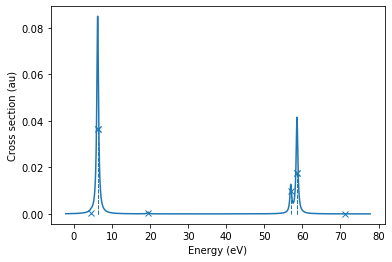

In [112]:
# We can print a summary of the results
print(adc_results.describe())

# Or plot the absorbtion spectrum
adc_results.plot_spectrum(label='adc(1)')

```python
# Compare the two results for the excitation energies
# Gator saves them in the member variable "excitation_energy"
print("Closed-shell ADC(1)/STO-3G eigenvalues:\n", ...)
print("\nADC(1)/STO-3G singlet excitation energies:\n", ...)
```

In [15]:
# Compare the two results for the excitation energies
print("Closed-shell ADC(1)/STO-3G eigenvalues:\n", adc1_eigvals)
print("\nADC(1)/STO-3G singlet excitation energies:\n", adc_results.excitation_energy)

Closed-shell ADC(1)/STO-3G eigenvalues:
 [0.16547 0.22819 0.22819 0.71508 2.09288 2.1528  2.1528  2.61434]

ADC(1)/STO-3G singlet excitation energies:
 [0.16547 0.22819 0.22819 0.71508 2.09288 2.1528  2.1528  2.61434]


- You should see that the two results are identical

## Obtain and diagonalize the full ADC(1) matrix

- One can get the full ADC(1) matrix in spin-orbital basis from Gator
- Confirm that it is four times as large as the closed-shell restricted one (having $\alpha\alpha, \alpha\beta, \beta\alpha$, and $\beta\beta$ blocks)
- The next task is to diagonalize it and have a look at the excitation energies and their degeneracies
- Can you assign term symbols (singlet or triplet, $\Sigma$ or $\Pi$ state) to the respective excited states?
    - Hint: the symmetry labels of the orbitals and degeneracies should be able to help you

```python
# This is the full matrix
gator_adc_matrix = adc_results.matrix.to_ndarray()
# Print the matrix and its shape
...
```

In [9]:
gator_adc_matrix = adc_results.matrix.to_ndarray()
print(gator_adc_matrix.shape)
print(gator_adc_matrix)

(32, 32)
[[ 2.07311 -0.      -0.      ...  0.       0.      -0.01296]
 [-0.       2.14264  0.      ... -0.00831  0.       0.     ]
 [-0.       0.       2.14264 ...  0.      -0.00831 -0.     ]
 ...
 [ 0.      -0.00831  0.      ...  0.20128  0.       0.     ]
 [ 0.       0.      -0.00831 ...  0.       0.20128 -0.     ]
 [-0.01296  0.      -0.      ...  0.      -0.       0.59268]]


```python
# Diagonalize the ADC(1) matrix from Gator to obtain excitation energies and vectors
gator_adc1_eigvals, gator_adc1_eigvecs = np.linalg.eigh(...)

print("Excitation energies from spin-orbital ADC(1)/STO-3G matrix:\n", ...)
```

In [10]:
# Diagonalize the ADC(1) matrix from Gator to obtain excitation energies and vectors
gator_adc1_eigvals, gator_adc1_eigvecs = np.linalg.eigh(gator_adc_matrix)
print("Excitation energies from spin-orbital ADC(1)/STO-3G matrix:\n", gator_adc1_eigvals)

Excitation energies from spin-orbital ADC(1)/STO-3G matrix:
 [0.13954 0.13954 0.13954 0.16547 0.17408 0.17408 0.17408 0.17408 0.17408
 0.17408 0.22819 0.22819 0.47721 0.47721 0.47721 0.71508 2.05306 2.05306
 2.05306 2.09288 2.13277 2.13277 2.13277 2.13277 2.13277 2.13277 2.1528
 2.1528  2.60108 2.60108 2.60108 2.61434]


```{toggle}
- The first excited state is triply (spin) degenerate: $^3\Sigma$
- The second one is singly degenerate: $^1\Sigma$
- The third one is six (two spatial and three spin) times degenerate: $^3\Pi$
- The fourth one is doubly (spatial) degenerate: $^1\Pi$
- The fifth one is again triply degenerate: $^3\Sigma$
- The sixth one is again singly degenerate: $^1\Sigma$
- This pattern then repeats for the following (core-excited) states
- $\Sigma$ states ($\Lambda = 0$) arise from $\sigma \to \sigma^*$ transitions, $\Pi$ states ($\Lambda = \pm 1$) from $\sigma \to \pi^*$ transitions
```

```python
# With gator, one can also look at the excitation vectors ...
print("ph vector shape:", adc_results.excitation_vector[0].ph.shape)

# ... and have it print out the most important vector amplitudes
print(adc_results.describe_amplitudes())
```

In [11]:
# With gator, one can also look at the excitation vectors ...
print("ph vector shape:", adc_results.excitation_vector[0].ph.shape)
# ... and have it print out the most important vector amplitudes
print(adc_results.describe_amplitudes())

ph vector shape: (4, 8)
+-----------------------------------+
| State   0 ,     0.1654741 au      |
+-----------------------------------+
| HOMO   -> LUMO    a->a     +0.707 |
| HOMO   -> LUMO+3  a->a    -0.0118 |

+-----------------------------------+
| State   1 ,     0.2281949 au      |
+-----------------------------------+
| HOMO   -> LUMO+2  a->a     +0.596 |
| HOMO   -> LUMO+1  a->a      -0.38 |

+-----------------------------------+
| State   2 ,     0.2281949 au      |
+-----------------------------------+
| HOMO   -> LUMO+1  a->a     +0.596 |
| HOMO   -> LUMO+2  a->a      +0.38 |

+-----------------------------------+
| State   3 ,      0.715084 au      |
+-----------------------------------+
| HOMO   -> LUMO+3  a->a     +0.707 |
| HOMO   -> LUMO    a->a    +0.0117 |

+-----------------------------------+
| State   4 ,      2.092884 au      |
+-----------------------------------+
| HOMO-1 -> LUMO    a->a     -0.707 |

+-----------------------------------+
| State   5 ,      2.

- You can also calculate the triplet states to confirm that your assignments were correct
- Info: setting `states=...` calculates both singlet and triplet states

```python
# Calculate triplet excited states
adc_triplet_results = gator.run_adc(lih, basis, scf, verbose=False, method='adc1',
                            triplets=nexc, tol=1e-5)

# Print the triplet excitation energies and compare 
...
```

In [16]:
adc_triplet_results = gator.run_adc(lih, basis, scf, verbose=False, method='adc1',
                            triplets=nexc, tol=1e-5, frozen_core=None, frozen_virtual=None)

print(adc_triplet_results.describe())

print(adc1_eigvals)
print(adc_results.excitation_energy)
print(adc_triplet_results.excitation_energy)

Starting adc1 triplet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8    3.2231e-30   55ms  [0.13954 0.17408 0.17408 0.47721 2.05306 2.13277 2.13277]
=== Converged ===
    Number of matrix applies:    8
    Total solver time:           60.217ms
+----------------------------------------------------+
| adc1                          triplet ,  converged |
+----------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2  |
|          (au)           (eV)                       |
|  0     0.1395385      3.797035   0.0000         1  |
|  1     0.1740783      4.736913   0.0000         1  |
|  2     0.1740783      4.736913   0.0000         1  |
|  3     0.4772148      12.98568   0.0000         1  |
|  4      2.053065      55.86674   0.0000         1  |
|  5      2.132768      58.03556   0.0000         1  |
|  6      2.132768      58.03556   0.0000         1  |
|  7      2.601084       70.7791   0.0000         1  |
+-------------

- Note that you can calculate 8 triplet states (at most), but they are all triply degenerate, so in total this corresponds to 24 states
- Together with the 8 singlets this gives 32 states, the dimension of the full ADC(1)/STO-3G matrix for LiH

## Core-excited states and core-valence separation (CVS) approximation

- From the above results for the (singlet or triplet) excitation energies, you see that they can be divided into two groups (consisting of 4 excited states each):
  - Those with an excitation energy $<$0.75 Hartree (singlets) or $<$0.5 Hartree (triplets)
  - Those with an excitation energy $>$2 Hartree
- The first group can be considered __valence excitations__ (from the filled bonding orbital), the second group are __core excitations__ (from the Li 1s orbital)
- __Core-excited states__ can also be targeted directly by employing the CVS approximation
- Perform a CVS-ADC(1) calculation with Gator by setting the corresponding method, adjusting the number of states, and setting `core_orbitals=1`
- Compare the excitation energies with the corresponding ones from the previous calculation

```python
# Run CVS-ADC(1) calculation with Gator
...

# Compare the CVS-ADC(1) results with the core-excitation energies from the full (singlet) diagonalization (convert to eV)
...
```

In [17]:
cvsadc_results = gator.run_adc(lih, basis, scf, verbose=False,
                            method='cvs-adc1', core_orbitals=1, singlets=nvir, tol=1e-5)

print(cvsadc_results.describe())

print("CVS-ADC(1)/STO-3G excitation energies:\t", cvsadc_results.excitation_energy * au2ev)
print("ADC(1)/STO-3G core excitation energies:\t", adc_results.excitation_energy[-nvir:] * au2ev)

Starting cvs-adc1 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     4    3.1083e-31   15ms  [2.09256 2.15253 2.15253 2.61433]
=== Converged ===
    Number of matrix applies:    4
    Total solver time:           17.265ms
+----------------------------------------------------+
| cvs-adc1                      singlet ,  converged |
+----------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2  |
|          (au)           (eV)                       |
|  0       2.09256      56.94145   0.0683         1  |
|  1      2.152531      58.57335   0.1135         1  |
|  2      2.152531      58.57335   0.1135         1  |
|  3      2.614332       71.1396   0.0000         1  |
+----------------------------------------------------+

CVS-ADC(1)/STO-3G excitation energies:	 [56.94145 58.57335 58.57335 71.1396 ]
ADC(1)/STO-3G core excitation energies:	 [56.95026 58.58059 58.58059 71.13974]


- Repeat the SCF calculation with the NaH molecule (just replace Li by Na in the molecule string)
- Diagonalize the ADC(1) matrix for all singlets (with Gator or your own implementation)
- Compare the core-excitation energies to the results from a corresponding CVS-ADC(1) calculation

```python
# Sodium hydride xyz string and molecule object
...

# Basis set
...

# Run SCF through Gator
...
```

In [18]:
# Sodium hydride molecule
nah_xyz="""2

Na  0.000000   0.000000   0.000000
H   0.000000   0.000000   1.000000
"""
nah = vlx.Molecule.from_xyz_string(nah_xyz)

# Basis set
basis_nah = vlx.MolecularBasis.read(nah, basis_set_label)

# Run SCF through Gator
scf_nah = gator.run_scf(nah, basis_nah, conv_thresh=1e-10, verbose=True)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

```python
# Number of MOs, occupied and virtual orbitals, and excited states for NaH
# How many excited states are there?
...
```

In [19]:
# Number of orbitals and excited states
nocc_nah = nah.number_of_alpha_electrons()
norb_nah = scf_nah.scf_tensors['C_alpha'].shape[1]
nvir_nah = norb_nah - nocc_nah
nexc_nah = nocc_nah * nvir_nah # number of excited (singlet or triplet) states in ADC(1)

```python
# Calculate all possible singlet excited states with ADC(1)
...

# Print the excitation energies
...
```

In [20]:
adc_results_nah = gator.run_adc(nah, basis_nah, scf_nah, verbose=False, method='adc1',
                            singlets=nexc_nah, tol=1e-5)
print("\nADC(1)/cc-pVDZ singlet excitation energies:\n", adc_results_nah.excitation_energy)

Starting adc1 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    24    3.9973e-27  159ms  [0.39324 0.52704 0.52704 1.02922 1.33518 1.33518 1.40744]
=== Converged ===
    Number of matrix applies:    24
    Total solver time:           182.452ms

ADC(1)/cc-pVDZ singlet excitation energies:
 [ 0.39324  0.52704  0.52704  1.02922  1.33518  1.33518  1.40744  1.50255
  1.50876  1.50876  1.5536   1.5536   1.86846  2.08246  2.08246  2.21844
  2.75043  2.89832  2.89832  3.45754 39.9343  40.08268 40.08268 40.74604]


```python
# Calculate all possible core-excited states with CVS-ADC(1)
# How many are there?
...

# Compare the results of the core-excitation energies
...
```

In [21]:
# Since there is only one core orbital to excite from, the number of core-excited states
# corresponds to the number of virtual orbitals in NaH
cvsadc_results_nah = gator.run_adc(nah, basis_nah, scf_nah, verbose=False,
                            method='cvs-adc1', core_orbitals=1, singlets=nvir_nah, tol=1e-5)

print("CVS-ADC(1)/STO-3G excitation energies:\t", cvsadc_results_nah.excitation_energy * au2ev)
print("ADC(1)/STO-3G core excitation energies:\t", adc_results_nah.excitation_energy[-nvir_nah:] * au2ev)

Starting cvs-adc1 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     4    4.9437e-28   13ms  [39.93425 40.08263 40.08263 40.74602]
=== Converged ===
    Number of matrix applies:    4
    Total solver time:           14.804ms
CVS-ADC(1)/STO-3G excitation energies:	 [1086.66624 1090.70401 1090.70401 1108.75557]
ADC(1)/STO-3G core excitation energies:	 [1086.6677  1090.70529 1090.70529 1108.75617]


- You should see that the CVS approximation is even better for NaH than for LiH, which is due to the larger energy separation of the core and valence orbitals

## Transition moments and oscillator strengths

In order to simulate a UV/vis or X-ray spectrum, apart from the excitation energies
also the spectral intensity is required. This is done by means of so-called _oscillator strengths_,
which are available from the excitation energies and the _transition dipole moments_.
In order to obtain the latter, the ground- to excited-state transition density matrices
$\mathbf{x} = \mathbf{Y}^\dagger \mathbf{f}$ are needed.
Through first order in perturbation theory, the non-vanishing part is given by

$$
x_{ia} = Y_{ia} - \sum_{jb} Y_{jb} \, t_{ijab} \, ,
$$

where $Y_{ia}$ denotes an element of the excitation vector,
and the [$t$-amplitudes](sec:calc-mp-t-amplitudes) are $t_{ijab} = \frac{\langle ab || ij \rangle}{\varepsilon_{a} + \varepsilon_{b} - \varepsilon_{i} - \varepsilon_{j}}$.

The transition dipole moment $T_{m}$ for the component $m \in \{ x,y,z \}$ is obtained
by contracting the transition density matrix with the corresponding dipole integrals $\mu_{ia}^{m}$,

$$
T_{m} = \sum_{ia} x_{ia} \, \mu_{ia}^{m} \, ,
$$

and the dimensionless oscillator strength $f$, commonly used for relative intensities in the simulation
of electronic spectra, is obtained from quantities in atomic units as

$$
f = \frac23 \omega \, \sum_{m} T_{m}^2 \, ,
$$

where $\omega$ is the excitation energy of the corresponding excited state.

```{note}
- The transition density matrices $\mathbf{x}$ are not symmetric, meaning that $x_{ia} \neq x_{ai}$. However, due to the symmetry of the dipole integrals, we could put $x_{ai}$ into $x_{ia}$.
- In the CIS scheme, $x_{ia} = Y_{ia}$ is correct through zeroth order only. As a matter of fact, this is the only place where the ADC(1) and CIS methods differ.
```

In [22]:
try:
    import adcc
except:
    raise ImportError("Could not import adcc. Please install.")

- Get the desired eigenvector and the $t$-amplitudes:

In [166]:
# Choose excited state
n_excstate = 0

# Eigenvector from Gator results
adc_eigenvector = adc_results.excitation_vector[n_excstate]['ph'].to_ndarray()

# t-amplitudes from adcc reference state
t2 = adcc.LazyMp(adc_results.reference_state).t2("o1o1v1v1").to_ndarray()

- Calculate transition moment (transition density matrix) by adding zeroth- and first-order terms:

```python
transmom = adc_eigenvector - ...
```

In [161]:
transmom = adc_eigenvector - np.einsum('jb,ijab->ia', adc_eigenvector, t2)
print("transmom:\n", transmom.shape, "\n", transmom)

transmom:
 (4, 8) 
 [[ 0.0064   0.       0.      -0.00181  0.       0.       0.       0.     ]
 [ 0.69874  0.       0.      -0.02647  0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.0064   0.       0.      -0.00181]
 [ 0.       0.       0.       0.       0.69874  0.       0.      -0.02647]]


- Get the dipole integrals and transform them to MO basis

In [163]:
# Dipole integrals in AO basis
dipole_drv = vlx.veloxchemlib.ElectricDipoleIntegralsDriver()
dipole_mats = dipole_drv.compute(lih, basis)
dipole_ints_ao = np.array((dipole_mats.x_to_numpy(), dipole_mats.y_to_numpy(),
               dipole_mats.z_to_numpy()))

# Transform them to MO basis
mo = scf.scf_tensors['C'] # MO coefficients
dipole_ints_mo = np.array([np.linalg.multi_dot([mo.T, dipole_ints_ao[x], mo]) for x in range(3)])
dipole_ints_ov = dipole_ints_mo[:, :nocc, nocc:]

- Calculate the transition dipole moments $T_{m}$
  - One problem arises since the ADC eigenvectors and $t$-amplitudes (and thus the transition moments $\mathbf{x}$) are given in a spin-orbital basis, but the dipole integrals in a basis of spatial orbitals
  - However, same-spin blocks blocks of $\mathbf{x}$ are equal in a closed-shell system, while opposite-spin blocks vanish
  - This means we can contract the $\alpha$-only block of the transition moments with the dipole integrals and multiply the result by 2 to account for the $\beta$-only block

```python
trans_dip_mom = ...
```

In [164]:
trans_dip_mom = 2 * np.einsum('ia,xia->x', transmom[:nocc, :nvir], dipole_ints_ov)
print("trans_dip_mom:\n", trans_dip_mom)

trans_dip_mom:
 [ 0.      -0.       0.15736]


- Get the corresponding excitation energy and calculate the oscillator strength $f$

```python
# Excitation energy
excitation_energy = adc_results.excitation_energy[n_excstate]

# Oscillator strength
osc = ...

# Compare to the result from Gator
print("\nOsc. str. from Gator:\n", adc_results.oscillator_strength[n_excstate])
```

In [169]:
excitation_energy = adc_results.excitation_energy[n_excstate]

osc = 2./3. * excitation_energy * np.dot(trans_dip_mom.T, trans_dip_mom)

print("Oscillator strength:\n", osc)
print("\nOsc. str. from Gator:\n", adc_results.oscillator_strength[n_excstate])


Oscillator strength:
 0.0027315991535243533

Osc str from Gator:
 0.0027315991535243507
